# Modélisation du risque de crédit et méthodes de scoring  
**Université de Nantes — IAE Nantes**  
**Année universitaire 2025–2026**

**Étudiants :** *CADET Timothée, DAËRON Djayan, HOUSSAIS Rémi*  
**Enseignant :** *WAFO FOUEKA Serge*  

---

## Introduction

L’évaluation du risque de crédit constitue un enjeu central pour les établissements financiers, tant pour sécuriser leurs portefeuilles que pour optimiser leurs décisions d’octroi. Dans ce projet, nous analysons un ensemble de données réelles afin de construire différents modèles de scoring permettant de prédire la probabilité de défaut d’un client.

L’objectif du travail est triple :  
1. **Préparer et structurer** les données grâce à une analyse exploratoire rigoureuse.  
2. **Construire et comparer plusieurs modèles**, allant des approches économétriques classiques (Logit, Probit) aux méthodes modernes de machine learning (arbres, forêts aléatoires, boosting…).  
3. **Interpréter les résultats** afin d’identifier les déterminants du risque de crédit et proposer une méthode de scoring performante et explicable.

Ce rapport présente successivement la préparation des données, le choix des méthodes d'encodage, les modèles retenus et leur évaluation.



## 1. Étapes préliminaires

### 1.1. Importer les librairies

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scikit_posthocs import outliers_gesd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import xgboost as xgb


### 1.2. Importer la base de données

In [130]:
# Charger un fichier SAS (.sas7bdat)

df = pd.read_sas("../data/raw/credit.sas7bdat", format="sas7bdat", encoding="latin1")


# Afficher les premières lignes

print(df.head())

   Cle  Comptes  Duree_credit Historique_credit Objet_credit  Montant_credit  \
0  1.0      1.0           6.0               A34          A43          1169.0   
1  2.0      2.0          48.0               A32          A43          5951.0   
2  3.0      4.0          12.0               A34          A46          2096.0   
3  4.0      1.0          42.0               A32          A42          7882.0   
4  5.0      1.0          24.0               A33          A40          4870.0   

   Epargne  Anciennete_emploi  Taux_effort Situation_familiale  ...  \
0      0.0                5.0          4.0                 A93  ...   
1      1.0                3.0          2.0                 A92  ...   
2      1.0                4.0          2.0                 A93  ...   
3      1.0                4.0          2.0                 A93  ...   
4      1.0                3.0          3.0                 A93  ...   

  Anciennete_domicile  Biens   Age  Autres_credits Statut_domicile Nb_credits  \
0          

### 1.3. Vérifier la nature des variables et effectuer les transformations nécessaires


In [131]:
# Nature des variables

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cle                  1000 non-null   float64
 1   Comptes              1000 non-null   float64
 2   Duree_credit         1000 non-null   float64
 3   Historique_credit    1000 non-null   object 
 4   Objet_credit         1000 non-null   object 
 5   Montant_credit       1000 non-null   float64
 6   Epargne              1000 non-null   float64
 7   Anciennete_emploi    1000 non-null   float64
 8   Taux_effort          1000 non-null   float64
 9   Situation_familiale  1000 non-null   object 
 10  Garanties            1000 non-null   object 
 11  Anciennete_domicile  1000 non-null   float64
 12  Biens                1000 non-null   object 
 13  Age                  1000 non-null   float64
 14  Autres_credits       1000 non-null   object 
 15  Statut_domicile      1000 non-null   ob

Le jeu de données comporte à la fois des variables continues (par exemple `Age`, `Montant_credit`, `Duree_credit`) et des variables qualitatives ou discrètes (`Comptes`, `Historique_credit`, `Objet_credit`, `Situation_familiale`, etc.).  

Certaines variables numériques sont en réalité **discrètes** et ne représentent pas une échelle continue (comme `Comptes`, `Nb_credits` ou `Nb_pers_charge`). Pour ces variables, il est plus pertinent de les traiter comme **catégorielles**, afin que les modèles reconnaissent correctement qu’il s’agit de classes distinctes et non d’une grandeur ordonnée.

Pour préparer le jeu de données à l'analyse et à la modélisation, les colonnes ont été séparées en **numériques** et **catégorielles** :

- Les colonnes `"Age"`, `"Duree_credit"` et `"Montant_credit"` sont conservées comme **numériques** (`float64`) car elles sont continues et permettent d'effectuer des calculs statistiques ainsi qu’alimenter directement les modèles linéaires.

- Toutes les autres colonnes ont été converties en **catégorielles** (`category`). Certaines colonnes peuvent sembler numériques mais elles sont en réalité **discrètes** et représentent des catégories (par exemple : `Nb_credits`, `Anciennete_emploi`).  

Les principales raisons de cette conversion sont :
1. **Respect de la nature des données** : les valeurs représentent des catégories et non des quantités continues, éviter de les traiter comme numériques prévient toute interprétation erronée ou biais dans les modèles.  
2. **Optimisation mémoire** : les colonnes catégorielles sont plus économes en mémoire que les colonnes numériques.  
3. **Préparation pour les modèles** : la plupart des modèles (Logistic Regression, Random Forest, CatBoost…) exploitent mieux les variables catégorielles via One-Hot Encoding ou encodage interne, ce qui améliore à la fois performance et interprétation.

Cette transformation garantit que chaque variable est traitée selon sa nature réelle et prépare le dataset pour les étapes suivantes de modélisation statistique et de machine learning.


In [132]:
# Transformer les types

# Définir les colonnes numériques
num_cols = ["Age", "Duree_credit", "Montant_credit"]

# Boucle sur toutes les colonnes
for col in df.columns:
    if col not in num_cols:
        # Convertir seulement si ce n'est pas dans num_cols
        df[col] = df[col].astype('category')
    else:
        # S'assurer que les colonnes numériques sont bien float
        df[col] = df[col].astype('float64')

# Vérification
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cle                  1000 non-null   category
 1   Comptes              1000 non-null   category
 2   Duree_credit         1000 non-null   float64 
 3   Historique_credit    1000 non-null   category
 4   Objet_credit         1000 non-null   category
 5   Montant_credit       1000 non-null   float64 
 6   Epargne              1000 non-null   category
 7   Anciennete_emploi    1000 non-null   category
 8   Taux_effort          1000 non-null   category
 9   Situation_familiale  1000 non-null   category
 10  Garanties            1000 non-null   category
 11  Anciennete_domicile  1000 non-null   category
 12  Biens                1000 non-null   category
 13  Age                  1000 non-null   float64 
 14  Autres_credits       1000 non-null   category
 15  Statut_domicile      1

In [133]:
# Recoder la variable Cible en 0 et 1

df['Cible'] = df['Cible'].map({1: 0, 2: 1})

La variable `Cible` indiquait initialement l’état du client avec deux modalités codées 1 et 2. Pour faciliter la modélisation et respecter la convention courante des modèles binaires, nous avons recodé cette variable en 0 et 1 :  

- `0` → client non-défaillant  
- `1` → client défaillant  

Ce recodage permet d’assurer une compatibilité directe avec les modèles de classification binaire (Logit, Probit, Random Forest, CatBoost, etc.) et facilite l’interprétation des probabilités prédites.

## 2. Analyse exploratoire et préparation des données

### 2.1. Analyse des valeurs manquantes

In [134]:
df.isnull().sum().sum()

np.int64(0)

Le jeu de données a été vérifié pour identifier d'éventuelles valeurs manquantes. Le résultat étant **0**, cela indique qu’aucune donnée n’est manquante dans l’ensemble du DataFrame.  

Cette situation simplifie grandement la préparation des données, car il n’est pas nécessaire d’appliquer de méthodes d’imputation ou de suppression de lignes/colonnes pour traiter les valeurs manquantes. Nous pouvons donc passer directement à l’analyse des outliers.


### 2.2. Traitement des outliers

#### 2.2.1. Visualiser les boxplots des variables quantitatives

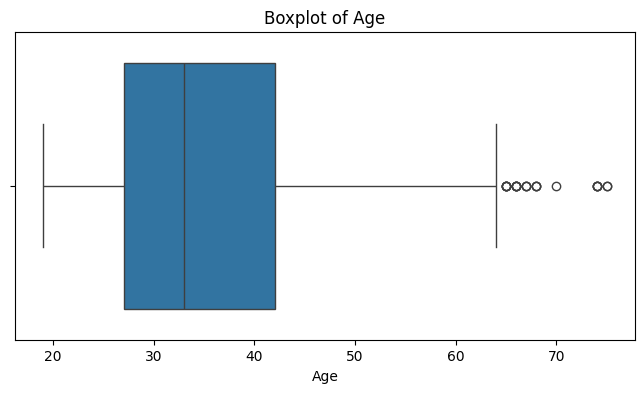

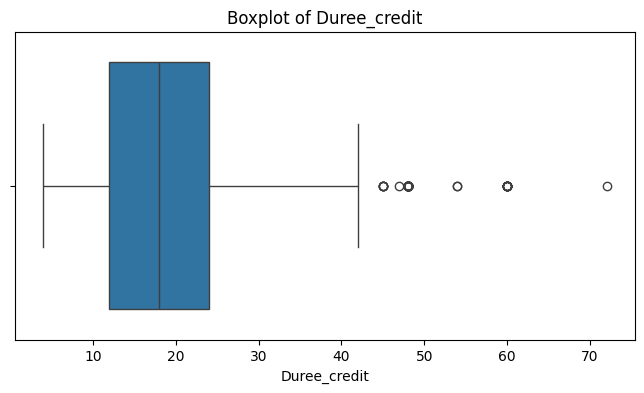

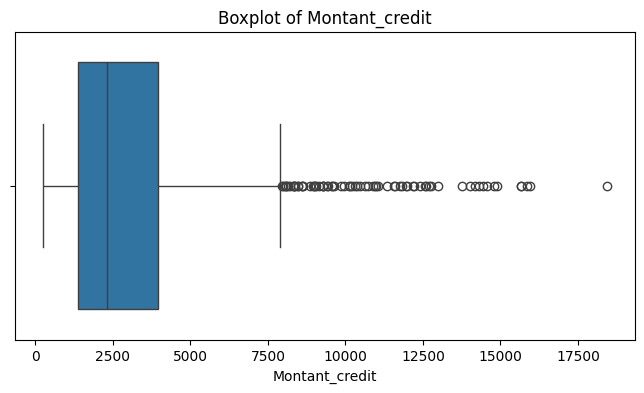

In [135]:
numeric_cols = ['Age', 'Duree_credit', 'Montant_credit']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

Lors de l'analyse des boxplots pour les variables numériques, on remarque la présence de **plusieurs valeurs extrêmes**, qui se distinguent par des montants **anormalement élevés** par rapport au reste des données. Ces observations correspondent donc uniquement à des valeurs « trop grandes » et peuvent influencer les statistiques descriptives ainsi que l'apprentissage des modèles.  

Afin de prendre une décision éclairée, nous allons procéder à une **vérification systématique** de ces valeurs atypiques à l'aide de méthodes statistiques, et déterminer s'il est pertinent de les supprimer ou de les traiter différemment.


#### 2.2.2. Traiter les outliers

In [136]:
# Duree_credit

no_outlier = outliers_gesd(df["Duree_credit"], alpha=0.05, hypo=False)
len(no_outlier) # 1 outliers
df = df[df["Duree_credit"] != df["Duree_credit"].max()]

In [137]:
# Montant_credit

no_outlier = outliers_gesd(df["Montant_credit"], alpha=0.05, hypo=False)
len(no_outlier) # 5 outliers
df = df.drop(df.nlargest(5, "Montant_credit").index)


In [138]:
# Age

no_outlier = outliers_gesd(df["Age"], alpha=0.05, hypo=False)
len(no_outlier) # pas outliers

994

Pour les variables numériques, nous avons utilisé la méthode **GESD (Generalized Extreme Studentized Deviate)** afin d’identifier les valeurs atypiques. Cette méthode permet de détecter statistiquement les observations extrêmes qui s’écartent significativement de la distribution des données.  

Au total, **6 valeurs extrêmes** ont été identifiées et supprimées (1 dans `Duree_credit` et 5 dans `Montant_credit`), tandis que `Age` n'en présente aucune. Cette étape permet de nettoyer le jeu de données et d’améliorer la fiabilité des statistiques descriptives et des modèles de scoring.


In [139]:
df.shape

(994, 21)

### 2.3. Statistiques descriptives univariées

In [140]:
# Statistiques descriptives univariées numériques 

num_stats = df[num_cols].describe().T
num_stats['variance'] = df[num_cols].var()
num_stats['skewness'] = df[num_cols].skew()
num_stats['kurtosis'] = df[num_cols].kurt()
num_stats['missing'] = df[num_cols].isna().sum()

print(num_stats)


                count         mean          std    min     25%     50%  \
Age             994.0    35.558350    11.362254   19.0    27.0    33.0   
Duree_credit    994.0    20.709256    11.801521    4.0    12.0    18.0   
Montant_credit  994.0  3203.331992  2672.860398  250.0  1364.0  2302.5   

                   75%      max      variance  skewness  kurtosis  missing  
Age               42.0     75.0  1.291008e+02  1.023731  0.609106        0  
Duree_credit      24.0     60.0  1.392759e+02  1.056352  0.767984        0  
Montant_credit  3956.5  14896.0  7.144183e+06  1.788120  3.313785        0  


Après le retrait des valeurs atypiques, les variables numériques `"Age"`, `"Duree_credit"` et `"Montant_credit"` montrent des caractéristiques plus représentatives de la population typique des clients.

- **Age** : La distribution est légèrement asymétrique vers les âges plus élevés, avec une moyenne autour de 35 ans et une médiane légèrement inférieure. Cela reflète la majorité des clients concentrés dans une tranche d'âge centrale.  

- **Durée du crédit** : La distribution est légèrement positive, indiquant quelques crédits plus longs que la moyenne, mais la suppression de l’outlier permet de mieux comprendre la durée typique des crédits.  

- **Montant du crédit** : La distribution reste asymétrique, avec quelques crédits très élevés, mais la suppression des valeurs extrêmes rend les statistiques plus représentatives des montants habituels.

**Intérêt de cette analyse** :  
1. Obtenir une vision plus réaliste et représentative des clients typiques.  
2. Réduire l’influence des valeurs extrêmes, ce qui améliore la fiabilité des statistiques descriptives.  
3. Préparer les données pour une modélisation statistique et machine learning plus stable et interprétable.

In [141]:
# Sélectionner les colonnes catégorielles

cat_cols = df.select_dtypes(include='category').columns
cat_cols = cat_cols.drop('Cle')


# Liste pour stocker les stats

summary = []


# Statistiques de base pour chaque catégorie

for col in cat_cols:
    counts = df[col].value_counts()
    props = df[col].value_counts(normalize=True) * 100  # en %
    
    # Créer une chaîne pour résumer la répartition
    repartition = ", ".join([f"{idx}: {prop:.1f}%" for idx, prop in props.items()])
    
    summary.append({
        "Variable": col,
        "Nb modalités": df[col].nunique(),
        "Modalité dominante": counts.idxmax(),
        "Effectif dominante": counts.max(),
        "Top 3 (%)": f"{props.head(3).sum():.1f}%",
        "Répartition (%)": repartition
    })


# Transformer en DataFrame pour un joli tableau
summary_df = pd.DataFrame(summary)
print(summary_df)


               Variable  Nb modalités Modalité dominante  Effectif dominante  \
0               Comptes             4                4.0                 393   
1     Historique_credit             5                A32                 527   
2          Objet_credit             9                A43                 278   
3               Epargne             5                1.0                 598   
4     Anciennete_emploi             5                3.0                 336   
5           Taux_effort             4                4.0                 476   
6   Situation_familiale             4                A93                 545   
7             Garanties             3               A101                 902   
8   Anciennete_domicile             4                4.0                 411   
9                 Biens             4               A123                 328   
10       Autres_credits             3               A143                 809   
11      Statut_domicile             3   

Les variables qualitatives montrent une forte concentration sur certaines modalités :  

- Certaines catégories sont très majoritaires, par exemple `Garanties` = A101 (≈ 91%), `Nb_pers_charge` = 1 (≈ 84%) ou `Cible` = 0 (≈ 70%).  
- D’autres variables présentent une répartition plus équilibrée, comme `Telephone` ou `Type_emploi`, permettant une discrimination plus fine entre les clients.  
- Les variables avec de nombreuses modalités (ex. `Objet_credit`, `Historique_credit`) sont concentrées sur quelques classes principales représentant la majorité des clients, tandis que les autres modalités sont minoritaires.

**Interprétation globale :**  
- Ces distributions permettent d’identifier les modalités dominantes et les classes rares qui pourraient nécessiter un regroupement ou un traitement particulier avant la modélisation.  
- La forte concentration sur certaines modalités peut influencer les modèles statistiques et machine learning, et il est important de préparer correctement les encodages pour que chaque variable soit représentée de façon appropriée.  
- Cette synthèse offre une vue d’ensemble de la structure du dataset et facilite l’interprétation des modèles de scoring à venir.


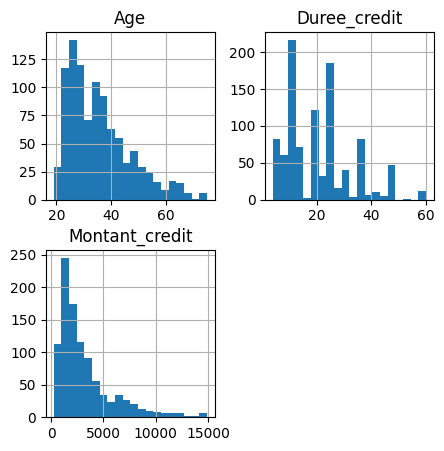

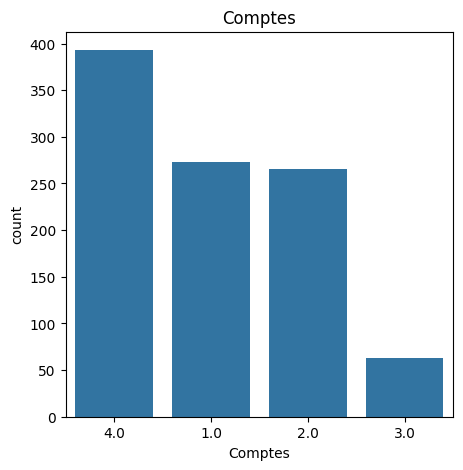

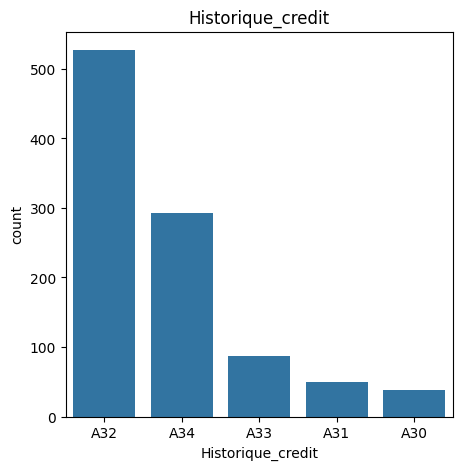

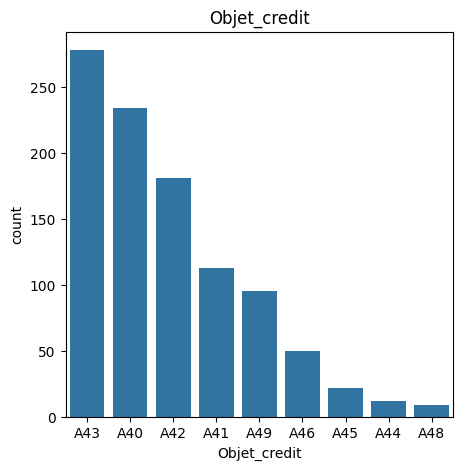

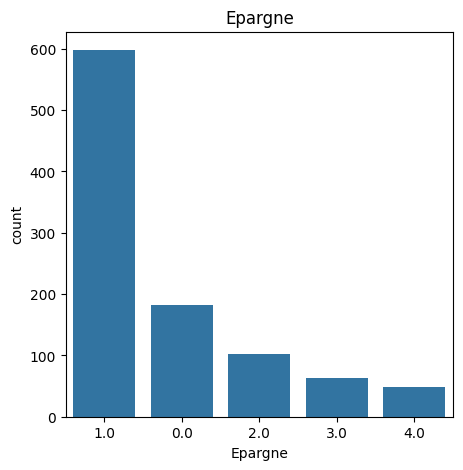

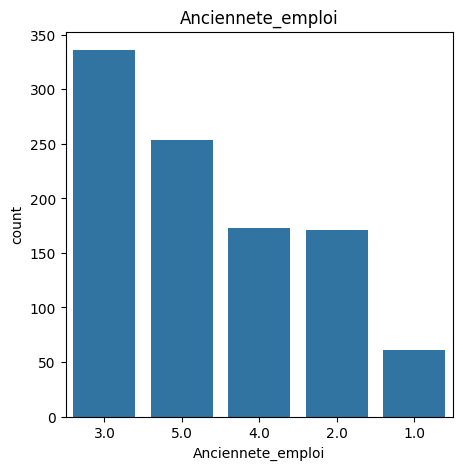

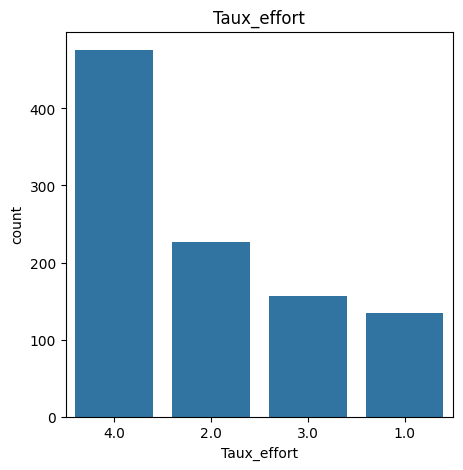

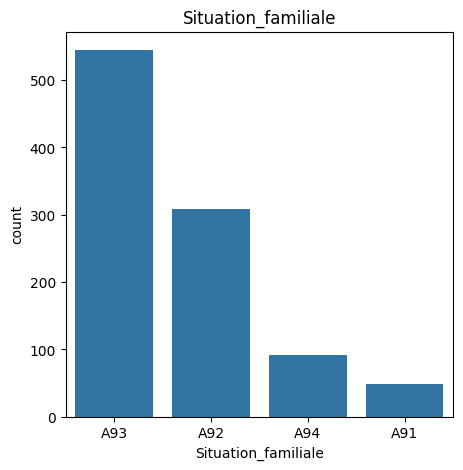

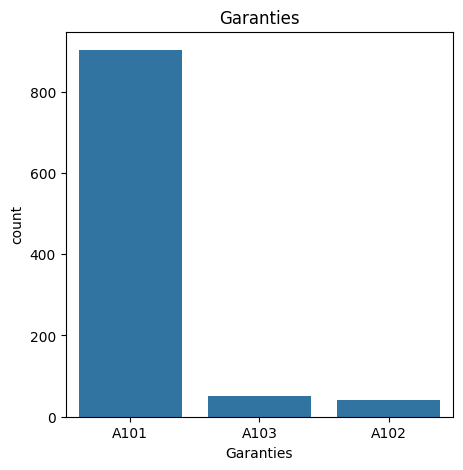

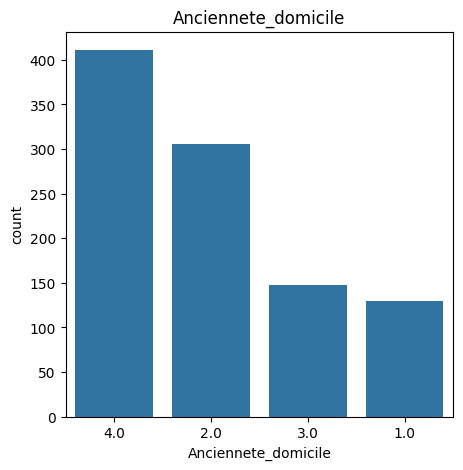

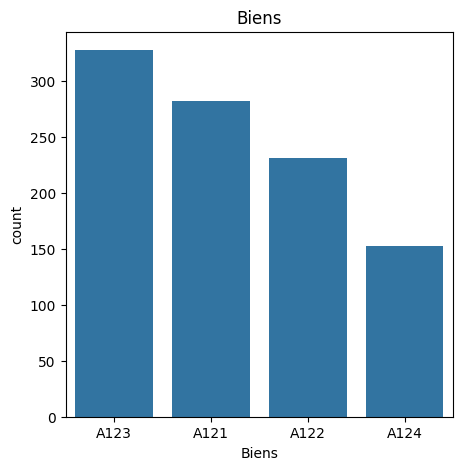

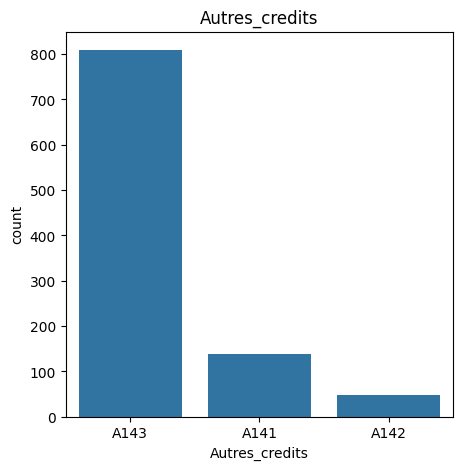

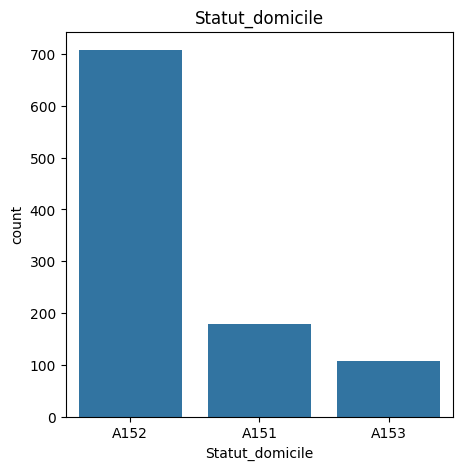

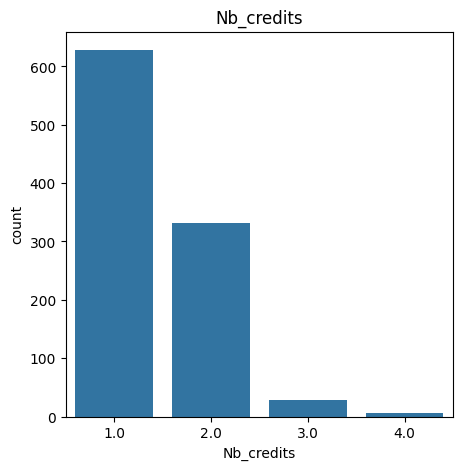

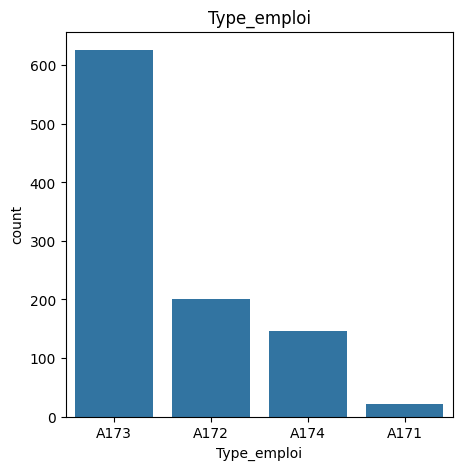

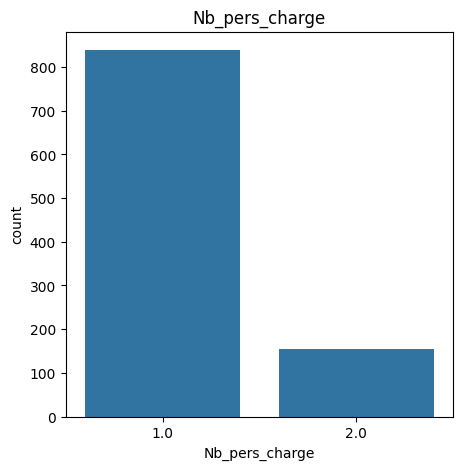

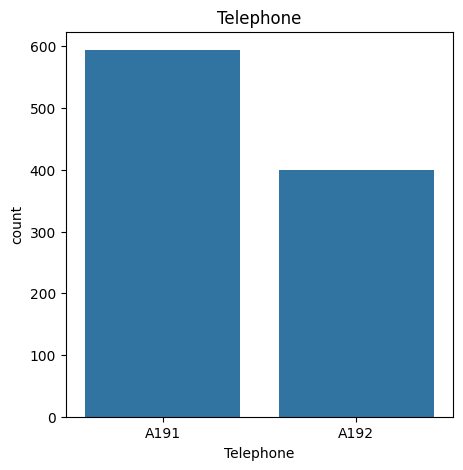

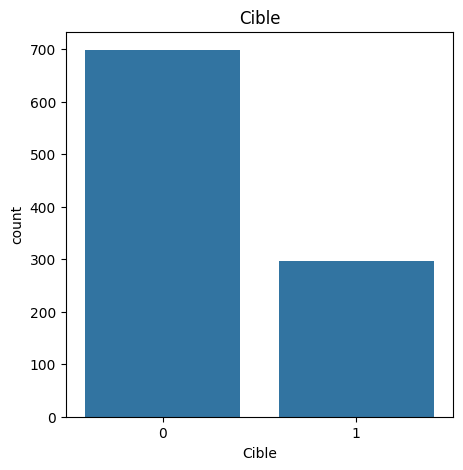

In [142]:
# Distribution numérique
df[num_cols].hist(bins=20, figsize=(5,5))
plt.show()

# Distribution catégorielle (bar plot pour chaque variable catégorielle)
for col in cat_cols:
    plt.figure(figsize=(5,5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(col)
    plt.show()


### 2.4. Statistiques descriptives bivariées

#### 2.4.1. Séparer `train` et `test`

Avant de calculer les corrélations ou le V de Cramer, le dataset a été **séparé en train et test** avec un ratio **80% / 20%**.  
- La séparation a été réalisée de manière **stratifiée sur la variable cible `Cible`**, afin de conserver la même proportion de clients défaillants et non-défaillants dans les deux ensembles.  
- L’objectif est de **prendre toutes les décisions d’ingénierie des features uniquement à partir du train**, afin d’éviter toute fuite de données depuis le test.  
- Les corrélations entre variables numériques et le V de Cramer entre variables catégorielles sont donc calculés **uniquement sur l’ensemble d’entraînement**.  
- Ces analyses permettent d’identifier des redondances, des variables fortement associées ou des patterns intéressants, qui guideront la création de nouvelles features et le choix des variables pour la modélisation, **sans utiliser aucune information issue du test**.


In [143]:
# Séparer notre jeu train et test

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Cible'])
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (795, 21), Test shape: (199, 21)


In [144]:
# Vérifier la répartition

def psi_single(feature_train, feature_test, buckets=10):
    """PSI pour variables numériques"""
    quantiles = np.linspace(0, 1, buckets + 1)
    bins = np.quantile(feature_train, quantiles)

    # éviter bins identiques
    bins = np.unique(bins)
    if len(bins) == 1:
        return 0

    train_counts, _ = np.histogram(feature_train, bins=bins)
    test_counts, _ = np.histogram(feature_test, bins=bins)

    train_perc = train_counts / len(feature_train)
    test_perc = test_counts / len(feature_test)

    psi = np.sum((train_perc - test_perc) * np.log((train_perc + 1e-6) / (test_perc + 1e-6)))
    return psi


def psi_categorical(feature_train, feature_test):
    """PSI pour variables catégorielles"""
    categories = sorted(set(feature_train.unique()) | set(feature_test.unique()))

    psi = 0
    for cat in categories:
        train_perc = (feature_train == cat).mean()
        test_perc = (feature_test == cat).mean()

        psi += (train_perc - test_perc) * np.log((train_perc + 1e-6) / (test_perc + 1e-6))

    return psi


def psi_all(train_df, test_df):
    psi_results = {}

    for col in train_df.columns:
        if col in ["Cible", "Cle"]:  # on ne compare jamais la cible (et la clé)
            continue

        if pd.api.types.is_numeric_dtype(train_df[col]):
            psi_results[col] = psi_single(train_df[col], test_df[col])
        else:
            psi_results[col] = psi_categorical(train_df[col].astype(str),
                                               test_df[col].astype(str))

    return pd.Series(psi_results).sort_values(ascending=False)

psi_scores = psi_all(train_df, test_df)
print(psi_scores)

Objet_credit           0.066063
Type_emploi            0.050879
Comptes                0.043578
Age                    0.042557
Anciennete_emploi      0.038182
Montant_credit         0.033290
Garanties              0.029177
Taux_effort            0.027896
Anciennete_domicile    0.019832
Nb_credits             0.016323
Biens                  0.016060
Epargne                0.010531
Statut_domicile        0.010479
Situation_familiale    0.010052
Duree_credit           0.008084
Historique_credit      0.003398
Autres_credits         0.001882
Nb_pers_charge         0.001141
Telephone              0.000192
dtype: float64


Afin de vérifier la **stabilité des distributions** entre les jeux *train* et *test*, nous avons calculé le **PSI (Population Stability Index)** pour l’ensemble des variables.  
L’objectif est de s’assurer que l’échantillonnage effectué lors du *train/test split* n’a pas introduit de rupture forte entre les deux populations.  

Le PSI permet de quantifier cette stabilité :
- **PSI < 0.1** → stabilité élevée, distributions similaires  
- **0.1 ≤ PSI < 0.25** → différences modérées  
- **PSI ≥ 0.25** → forte dérive, problème potentiel  

Dans notre cas, toutes les variables présentent un **PSI très faible**, généralement inférieur à 0.07.  
Cela indique que les distributions des variables dans le train et le test sont **cohérentes et comparables**, ce qui valide la qualité du découpage et garantit que le modèle ne sera pas entraîné sur une population trop différente de celle qu’il devra prédire.  

Plus concrètement :
- Les variables les plus “instables” comme *Objet_credit*, *Type_emploi* ou *Comptes* ont des PSI autour de 0.04–0.06, ce qui reste très faible.  
- La majorité des variables ont des PSI proches de 0, indiquant des distributions presque identiques.  
- Aucune variable ne dépasse le seuil de 0.1, ce qui confirme qu’il n’y a **aucun risque de dérive de population** dans notre split.

En résumé, le PSI confirme que **nos jeux train et test sont bien équilibrés**, et que le modèle construit à partir du train pourra généraliser correctement sur le test.


#### 2.4.2.  Corrélation

In [145]:
corr = train_df[numeric_cols].corr()
corr

,Age,Duree_credit,Montant_credit
Age,1.000000,-0.042288,0.024623
Duree_credit,-0.042288,1.000000,0.630504
Montant_credit,0.024623,0.630504,1.000000


La matrice de corrélation montre les relations linéaires entre les variables numériques :

- `Age` est faiblement corrélé avec `Duree_credit` et `Montant_credit` (corr ≈ 0), ce qui indique que l’âge du client n’influence pas directement la durée ou le montant du crédit.  
- `Duree_credit` et `Montant_credit` présentent une corrélation modérée (≈ 0.63), suggérant que les crédits plus longs ont tendance à être plus élevés.

**Variable croisée pour éviter les problèmes :**  
Pour limiter l’effet des corrélations lors de la modélisation et mieux représenter les relations entre variables, nous avons décidé de créer la variable croisée `Credit_ratio = Montant_credit / Duree_credit`.  
- Elle permet de représenter le **montant du crédit par unité de durée**, donnant ainsi une mesure plus pertinente de l’effort financier mensuel du client.  
- Cette transformation aide à **réduire l’effet de corrélation entre `Montant_credit` et `Duree_credit`** et facilite l’interprétation des modèles statistiques et de scoring.



In [146]:
# Création de la variable Credit_ratio

train_df['Credit_ratio'] = train_df['Montant_credit'] / train_df['Duree_credit']

test_df['Credit_ratio'] = test_df['Montant_credit'] / test_df['Duree_credit']

#### 2.4.3. Discrétiser les variables quantitatives

Nous avons décidé de **discrétiser les 2 variables numériques** (`Age` et `Credit_ratio`).  
- L’idée est de **transformer ces variables continues en tranches ou catégories**, ce qui nous permet de simplifier l’analyse et de mieux gérer les effets non linéaires.  
- Cela rend aussi les résultats plus **interprétables** : par exemple, on peut comparer des tranches d’âge ou de montant de crédit entre elles plutôt que de regarder des valeurs individuelles.  
- De plus, certaines méthodes comme les **arbres de décision ou les forêts aléatoires** gèrent plus naturellement les variables discrètes, ce qui peut améliorer la qualité des modèles.  
- En résumé, cette discrétisation nous aide à **regrouper les clients de manière cohérente** et à **faciliter l’identification des profils à risque**.

In [147]:
# Découpage de Âge

bins_age = [18, 25, 35, 45, 55, 100]
labels_age = ["18-25", "26-35", "36-45", "46-55", "56+"]
train_df["Age_cat"] = pd.cut(train_df["Age"], bins=bins_age, labels=labels_age, right=True, include_lowest=True)
train_df["Age_cat"].value_counts()

Age_cat
26-35    317
36-45    187
18-25    150
46-55     93
56+       48
Name: count, dtype: int64

Pour mieux analyser l’âge des clients et éventuellement l’utiliser comme variable catégorielle dans les modèles, nous avons créé des tranches d’âge logiques et économiquement pertinentes :  

- **18-25 ans** : jeunes adultes, souvent au début de leur activité professionnelle.  
- **26-35 ans** : jeunes actifs, phase d’établissement financier.  
- **36-45 ans** : clients en milieu de carrière, souvent stables financièrement.  
- **46-55 ans** : clients expérimentés, potentiellement avec des crédits ou projets plus importants.  
- **56+ ans** : clients seniors, souvent proches de la retraite.

**Interprétation :**  
- Ce découpage permet de capturer la répartition de l’âge de manière significative.  
- Chaque tranche contient suffisamment d’observations pour garantir une analyse fiable et exploitable pour la modélisation.  
- Les classes sont choisies de manière à refléter des étapes de vie et des profils financiers différents, facilitant ainsi l’interprétation économique des résultats.


In [148]:
# Découpage de Credit_ratio

bins_ratio = [0, 50, 150, 300, 600, 5000]
labels_ratio = ["Très faible", "Faible", "Moyen", "Élevé", "Très élevé"]
train_df["Credit_ratio_cat"] = pd.cut(train_df["Credit_ratio"], bins=bins_ratio, labels=labels_ratio, include_lowest=True)
train_df["Credit_ratio_cat"].value_counts()

Credit_ratio_cat
Faible         433
Moyen          267
Élevé           67
Très faible     17
Très élevé      11
Name: count, dtype: int64

**Découpage de la variable `Credit_ratio` en classes**  

Pour analyser le poids relatif du crédit par rapport aux revenus ou à la capacité financière, nous avons créé des catégories économiquement interprétables :  

- **Très faible** : clients avec un crédit très léger par rapport à leur situation financière.  
- **Faible** : clients avec un effort de crédit modéré, gérable facilement.  
- **Moyen** : clients avec un effort de crédit standard, représentatif de la majorité des clients.  
- **Élevé** : clients ayant une charge de crédit importante, pouvant représenter un risque plus élevé.  
- **Très élevé** : clients avec un crédit très lourd par rapport à leur capacité, potentiellement à risque.

**Interprétation :**  
- Le découpage permet de segmenter les clients selon la charge de crédit et facilite la détection des profils à risque.  
- Chaque catégorie contient un nombre suffisant d’observations pour permettre une analyse fiable.  
- Les classes sont définies pour refléter des niveaux de risque économique et aider à l’interprétation des modèles de scoring.


In [149]:
# Faire pareil pour test

test_df["Age_cat"] = pd.cut(test_df["Age"], bins=bins_age, labels=labels_age, right=True, include_lowest=True)
test_df["Credit_ratio_cat"] = pd.cut(test_df["Credit_ratio"], bins=bins_ratio, labels=labels_ratio, include_lowest=True)

In [150]:
# Retirer les colonens numériques transformées

cols_to_drop = ["Age", "Credit_ratio", "Duree_credit", "Montant_credit"]

train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)


In [151]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795 entries, 719 to 596
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cle                  795 non-null    category
 1   Comptes              795 non-null    category
 2   Historique_credit    795 non-null    category
 3   Objet_credit         795 non-null    category
 4   Epargne              795 non-null    category
 5   Anciennete_emploi    795 non-null    category
 6   Taux_effort          795 non-null    category
 7   Situation_familiale  795 non-null    category
 8   Garanties            795 non-null    category
 9   Anciennete_domicile  795 non-null    category
 10  Biens                795 non-null    category
 11  Autres_credits       795 non-null    category
 12  Statut_domicile      795 non-null    category
 13  Nb_credits           795 non-null    category
 14  Type_emploi          795 non-null    category
 15  Nb_pers_charge       795 n

#### 2.4.4. V de Cramer

In [152]:
# Fonction pour calculer le V de Cramer

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Colonnes catégorielles SAUF Cible et Cle
cat_cols = train_df.select_dtypes(include=['category']).columns
cat_cols = [c for c in cat_cols if c not in ['Cible', 'Cle']]

# Calcul du V de Cramer
cramers_v_values = {
    col: cramers_v(train_df[col], train_df['Cible']) 
    for col in cat_cols
}

# Tri décroissant
cramers_v_values_sorted = dict(
    sorted(cramers_v_values.items(), key=lambda x: x[1], reverse=True)
)

cramers_v_values_sorted


{'Comptes': np.float64(0.3397812605314372),
 'Historique_credit': np.float64(0.23476275212875808),
 'Epargne': np.float64(0.18166273672927719),
 'Biens': np.float64(0.1589774758526436),
 'Anciennete_emploi': np.float64(0.1475558897965531),
 'Statut_domicile': np.float64(0.14629567978157773),
 'Objet_credit': np.float64(0.14220558494266736),
 'Age_cat': np.float64(0.12028611071666861),
 'Autres_credits': np.float64(0.11685361891861072),
 'Situation_familiale': np.float64(0.08395794938108113),
 'Taux_effort': np.float64(0.08327848526499805),
 'Garanties': np.float64(0.07663809454976651),
 'Credit_ratio_cat': np.float64(0.07454303812888757),
 'Type_emploi': np.float64(0.035256474831436596),
 'Anciennete_domicile': np.float64(0.0),
 'Nb_credits': np.float64(0.0),
 'Nb_pers_charge': np.float64(0.0),
 'Telephone': np.float64(0.0)}


Afin d’évaluer la force d’association entre les variables catégorielles et la variable cible, nous avons calculé le V de Cramer sur l’ensemble d’entraînement.  
Les résultats montrent que les niveaux d’association restent globalement faibles à modérés, ce qui est cohérent avec un jeu de données de scoring, mais plusieurs variables ressortent plus fortement que d’autres.

- **Comptes** est la variable la plus liée à la cible, avec une association nettement supérieure aux autres.  
- **Historique_credit** et **Epargne** présentent également une influence notable, confirmant l’importance des informations financières passées et du niveau d’épargne dans la prédiction du risque.  
- Un second groupe de variables (comme *Biens*, *Anciennete_emploi*, *Statut_domicile* ou *Objet_credit*) montre une association plus modérée, mais reste informatif pour la modélisation.  
- Enfin, certaines variables affichent un V de Cramer nul (ex. *Anciennete_domicile*, *Nb_credits*, *Nb_pers_charge*, *Telephone*), indiquant qu’elles n’apportent aucune information sur la variable cible dans notre échantillon. Elles pourront donc être considérées comme non pertinentes dans les étapes suivantes.

Cette analyse nous permet d’identifier les variables ayant un réel pouvoir explicatif et d’orienter les choix de sélection et d’ingénierie de features sans risque de fuite d’information depuis l’ensemble


#### 2.4.5. Information Value

In [153]:
# Fonction pour calculer WoE et IV d'une colonne

def woe_iv(df, feature, target):
    lst = []
    for val in df[feature].unique():
        total = df[df[feature] == val].shape[0]
        good = df[(df[feature] == val) & (df[target] == 0)].shape[0]
        bad = df[(df[feature] == val) & (df[target] == 1)].shape[0]
        dist_good = good / df[df[target] == 0].shape[0] if df[df[target] == 0].shape[0] != 0 else 0
        dist_bad = bad / df[df[target] == 1].shape[0] if df[df[target] == 1].shape[0] != 0 else 0
        woe = np.log((dist_good + 0.0001) / (dist_bad + 0.0001))  # éviter div par zéro
        iv = (dist_good - dist_bad) * woe
        lst.append({'Value': val, 'WoE': woe, 'IV': iv})
    df_woe = pd.DataFrame(lst)
    iv_total = df_woe['IV'].sum()
    return iv_total


# Calcul de l'IV pour toutes les colonnes catégorielles sauf la cible

iv_values = {}
for col in train_df.select_dtypes(include=['category']).columns:
    if col not in ['Cible','Cle']:
        iv_values[col] = woe_iv(train_df, col, 'Cible')


# Tri décroissant

iv_values_sorted = dict(sorted(iv_values.items(), key=lambda item: item[1], reverse=True))
iv_values_sorted


{'Comptes': np.float64(0.6186640030327939),
 'Historique_credit': np.float64(0.2847162654993659),
 'Epargne': np.float64(0.22102094992292115),
 'Objet_credit': np.float64(0.16642733645109792),
 'Biens': np.float64(0.13866136455442046),
 'Anciennete_emploi': np.float64(0.1258165328021467),
 'Statut_domicile': np.float64(0.10958973392666387),
 'Age_cat': np.float64(0.0880141525757632),
 'Autres_credits': np.float64(0.07194971944437945),
 'Taux_effort': np.float64(0.052807124544851494),
 'Situation_familiale': np.float64(0.05209081889146636),
 'Credit_ratio_cat': np.float64(0.051234338471270166),
 'Garanties': np.float64(0.037652794475531604),
 'Type_emploi': np.float64(0.02470114576951235),
 'Nb_credits': np.float64(0.01644911036733475),
 'Anciennete_domicile': np.float64(0.009849316716830803),
 'Telephone': np.float64(0.0033239706374715793),
 'Nb_pers_charge': np.float64(0.0005264642648369815)}

Nous avons calculé l’Information Value (IV) pour l’ensemble des variables catégorielles du jeu d’entraînement, ce qui permet d’évaluer leur **pouvoir prédictif** par rapport à la variable cible.

Les ordres de grandeur classiques pour l’IV sont :
- **IV < 0.02** : pouvoir prédictif très faible  
- **0.02 ≤ IV < 0.1** : pouvoir prédictif faible  
- **0.1 ≤ IV < 0.3** : pouvoir prédictif moyen  
- **0.3 ≤ IV < 0.5** : forte capacité prédictive  
- **IV ≥ 0.5** : très forte capacité prédictive (souvent signe d’une variable très liée au risque)

Dans nos résultats :

- **Comptes** présente un IV très élevé (**≈ 0.62**), indiquant une variable **hautement discriminante** pour distinguer les bons et mauvais clients.  
- **Historique_credit**, **Epargne**, **Objet_credit**, **Biens** et **Anciennete_emploi** affichent un IV compris entre **0.12 et 0.28**, ce qui correspond à un **bon pouvoir prédictif**.
- **Statut_domicile**, **Age_cat**, **Autres_credits**, **Taux_effort**, **Situation_familiale** ou encore **Credit_ratio_cat** ont un IV entre **0.05 et 0.1**, ce qui indique un **pouvoir faible à modéré**, mais potentiellement utile dans un modèle multivarié.
- Enfin, certaines variables comme **Type_emploi**, **Nb_credits**, **Anciennete_domicile**, **Telephone** ou **Nb_pers_charge** ont un IV très faible (< 0.02), montrant qu’elles n’apportent que peu d’information en termes de discrimination du risque.

#### 2.4.6. Conserver les variables utiles

Pour la construction du modèle de scoring, nous avons retenu les variables suivantes : `Comptes`, `Historique_credit`, `Epargne`, `Objet_credit`, `Biens`, `Anciennete_emploi`, `Statut_domicile`, `Age`, `Autres_credits`, `Credit_ratio`, `Taux_effort`, `Situation_familiale` et `Cible`.

Ces variables ont été sélectionnées car elles présentent une forte capacité discriminante (Information Value élevée) et représentent des dimensions clés du profil client et de son crédit. Cette sélection permet de construire un modèle à la fois robuste, interprétable et concentré sur les informations les plus pertinentes pour évaluer le risque de crédit.

In [154]:
# Liste des variables à garder

selected_cols = [
    'Comptes', 'Historique_credit', 'Epargne', 'Objet_credit', 'Biens',
    'Anciennete_emploi', 'Statut_domicile', 'Age_cat', 'Autres_credits',
    'Credit_ratio_cat', 'Taux_effort', 'Situation_familiale', 'Cible', 'Cle'
]


# Créer le nouveau DataFrame df2

train_df2 = train_df[selected_cols].copy()
test_df2 = test_df[selected_cols].copy()


# Vérifier

print(train_df2.head())
print(train_df2.shape)

    Comptes Historique_credit Epargne Objet_credit Biens Anciennete_emploi  \
719     2.0               A30     2.0          A41  A123               5.0   
19      4.0               A32     3.0          A43  A123               5.0   
999     2.0               A34     2.0          A41  A123               1.0   
446     1.0               A32     1.0          A40  A123               2.0   
928     4.0               A32     0.0          A43  A123               5.0   

    Statut_domicile Age_cat Autres_credits Credit_ratio_cat Taux_effort  \
719            A152   26-35           A141            Élevé         3.0   
19             A152   26-35           A143           Faible         3.0   
999            A152   26-35           A143           Faible         3.0   
446            A152   26-35           A143           Faible         4.0   
928            A152     56+           A143           Faible         4.0   

    Situation_familiale Cible     Cle  
719                 A94     0   720.0  


### 2.5. Encoder les variables

In [155]:
import pandas as pd
import json

# 1. Identifier les colonnes catégorielles (hors clé)
cat_cols = [
    col for col in train_df2.columns
    if train_df2[col].dtype.name == "category" and col != "Cle"
]

# Dictionnaire pour sauvegarder les mappings
category_mapping = {}

# 2. Encodage du TRAIN + sauvegarde du mapping
for col in cat_cols:
    
    # Récupération des catégories du train
    categories = list(train_df2[col].cat.categories)
    
    # Création mapping catégorie → code
    mapping = {cat: i for i, cat in enumerate(categories)}
    
    # Sauvegarde dans le dict global
    category_mapping[col] = mapping
    
    # Encodage du train
    train_df2[col] = train_df2[col].map(mapping).astype("Int64")  # valeurs bien numériques

# 3. Sauvegarde du mapping sur disque (JSON)
with open("category_mapping.json", "w") as f:
    json.dump(category_mapping, f, indent=4)


In [156]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795 entries, 719 to 596
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Comptes              795 non-null    Int64   
 1   Historique_credit    795 non-null    Int64   
 2   Epargne              795 non-null    Int64   
 3   Objet_credit         795 non-null    Int64   
 4   Biens                795 non-null    Int64   
 5   Anciennete_emploi    795 non-null    Int64   
 6   Statut_domicile      795 non-null    Int64   
 7   Age_cat              795 non-null    Int64   
 8   Autres_credits       795 non-null    Int64   
 9   Credit_ratio_cat     795 non-null    Int64   
 10  Taux_effort          795 non-null    Int64   
 11  Situation_familiale  795 non-null    Int64   
 12  Cible                795 non-null    Int64   
 13  Cle                  795 non-null    category
dtypes: Int64(13), category(1)
memory usage: 138.7 KB


In [157]:
import json

# 1. Charger le mapping
with open("category_mapping.json", "r") as f:
    category_mapping = json.load(f)

# 2. Encodage du TEST
for col, mapping in category_mapping.items():
    # convertir le test en str pour correspondre aux clés du mapping
    test_series = test_df2[col].astype(str)
    
    # appliquer le mapping
    test_df2[col] = test_series.map(mapping).astype("float")
    
    # remplacer les inconnues par -1 et convertir en Int64
    test_df2[col] = test_df2[col].fillna(-1).astype("Int64")


Pour préparer les données à la modélisation, nous avons choisi d’encoder toutes les variables catégorielles en valeurs numériques. L’objectif est de rendre ces variables compréhensibles par les modèles statistiques et de machine learning, qui ne peuvent pas traiter directement des catégories textuelles.

Nous avons utilisé un encodage **label encoding**, c’est-à-dire que chaque modalité est transformée en un entier unique (0, 1, 2, …). Cette méthode est adaptée car nous n’avons pas de notion d’ordre économique entre les catégories : les nombres servent uniquement d’identifiants.

Il est important de noter que l’encodage a été réalisé **d’abord sur le jeu d’entraînement**, puis appliqué **exactement de la même façon sur le jeu de test**, en respectant l’ordre des catégories du train. Cela garantit la cohérence entre les deux ensembles et évite toute incohérence ou biais dans la modélisation.


## 3. Modélisation

## Méthode plus ancienne : Logit / Probit

In [158]:
# Séparer X / y + on enlève Clé
TARGET = 'Cible'
X_train = train_df2.drop(columns=[TARGET, 'Cle'])
y_train = train_df2[TARGET]
X_test  = test_df2.drop(columns=[TARGET, 'Cle'])
y_test  = test_df2[TARGET]

In [159]:
# S'assurer que train et test ont les mêmes colonnes
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
print(X_train.shape, X_test.shape)

(795, 12) (199, 12)


In [160]:
import statsmodels.api as sm

X_train = X_train.astype(float)  # toutes les colonnes numériques

# logit
logit_model = sm.Logit(y_train, X_train).fit()
print(logit_model.summary())

# probit
probit_model = sm.Probit(y_train, X_train).fit()
print(probit_model.summary())


Optimization terminated successfully.
         Current function value: 0.503551
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Cible   No. Observations:                  795
Model:                          Logit   Df Residuals:                      783
Method:                           MLE   Df Model:                           11
Date:              sam., 06 déc. 2025   Pseudo R-squ.:                  0.1735
Time:                        16:30:34   Log-Likelihood:                -400.32
converged:                       True   LL-Null:                       -484.36
Covariance Type:            nonrobust   LLR p-value:                 2.940e-30
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Comptes                -0.5878      0.074     -7.892      0.000      -0.734      -0.442
Hi

In [161]:
import statsmodels.api as sm

# Train
X_train_proc = sm.add_constant(X_train.astype(float), has_constant='add')
y_train_proc = y_train.astype(float)

# Logit / Probit
logit_model = sm.Logit(y_train_proc, X_train_proc).fit()
probit_model = sm.Probit(y_train_proc, X_train_proc).fit()

# Test
X_test_proc = sm.add_constant(test_df2.drop(columns=['Cible', 'Cle']).astype(float), has_constant='add')

# Vérifier dimensions
print(X_train_proc.shape)  # doit être (795,13)
print(X_test_proc.shape)   # doit être (199,13)

y_proba_logit = logit_model.predict(X_test_proc)
y_proba_probit = probit_model.predict(X_test_proc)

# Seuil 0.5 pour obtenir classes
y_pred_logit = (y_proba_logit >= 0.5).astype(int)
y_pred_probit = (y_proba_probit >= 0.5).astype(int)


Optimization terminated successfully.
         Current function value: 0.496489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495890
         Iterations 6
(795, 13)
(199, 13)



=== Évaluation Logit ===

Matrice de confusion :
 [[120  20]
 [ 38  21]]

Classification report :
               precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       140
         1.0       0.51      0.36      0.42        59

    accuracy                           0.71       199
   macro avg       0.64      0.61      0.61       199
weighted avg       0.69      0.71      0.69       199

AUC ROC : 0.7229
Indice de Gini : 0.4458


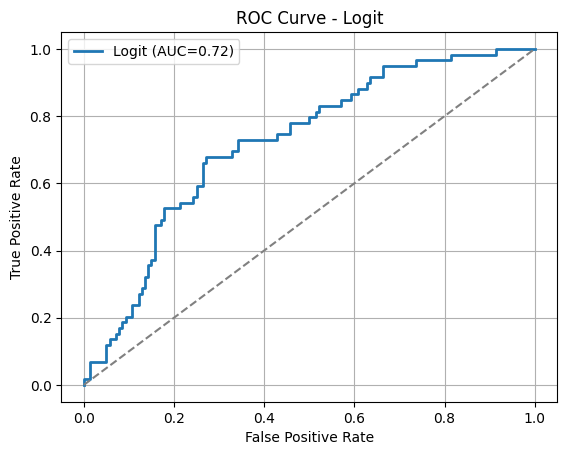


=== Évaluation Probit ===

Matrice de confusion :
 [[120  20]
 [ 39  20]]

Classification report :
               precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       140
         1.0       0.50      0.34      0.40        59

    accuracy                           0.70       199
   macro avg       0.63      0.60      0.60       199
weighted avg       0.68      0.70      0.68       199

AUC ROC : 0.7219
Indice de Gini : 0.4438


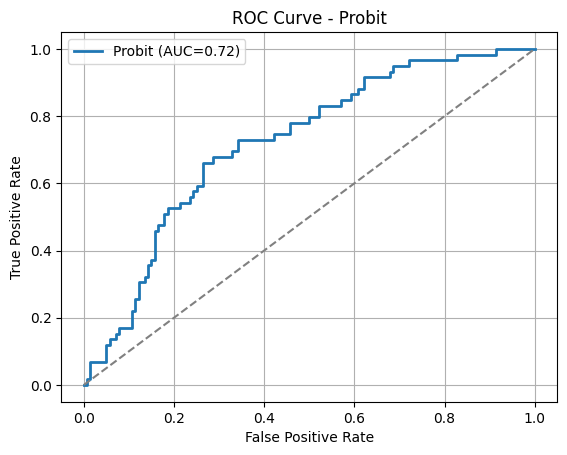

In [162]:
# Fonction d'évaluation
def eval_model(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n=== Évaluation {model_name} ===")
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    print("\nMatrice de confusion :\n", cm)
    print("\nClassification report :\n", classification_report(y_true, y_pred))
    
    # AUC & Gini
    auc = roc_auc_score(y_true, y_proba)
    gini = 2*auc - 1
    print(f"AUC ROC : {auc:.4f}")
    print(f"Indice de Gini : {gini:.4f}")
    
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc:.2f})')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Évaluer les deux modèles
eval_model(y_test, y_pred_logit, y_proba_logit, "Logit")
eval_model(y_test, y_pred_probit, y_proba_probit, "Probit")

## XGBOOST

XGBoost est un modèle de boosting basé sur des arbres de décision, qui combine plusieurs arbres faibles pour créer un modèle puissant capable de prédire des classes avec une grande précision.
Il optimise la performance en corrigeant les erreurs des arbres précédents et est très efficace sur des données tabulaires avec variables catégorielles ou numériques.

In [163]:
# Modèle XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

In [164]:
#Grid search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)


In [165]:
# Entraînement
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Meilleurs hyperparamètres :")
print(grid.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Meilleurs hyperparamètres :
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}


c:\Users\Timothée\Documents\M2 ECAP\Modélisation du risque de crédit et scoring\projet_scoring\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [166]:
# Prédictions
from sklearn.metrics import roc_auc_score
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred  = best_model.predict(X_test)

In [167]:
# AUC et GINI
auc = roc_auc_score(y_test, y_proba)
gini = 2 * auc - 1
print(f"\nAUC ROC : {auc:.4f}")
print(f"Indice de Gini : {gini:.4f}")


AUC ROC : 0.7504
Indice de Gini : 0.5007



Matrice de confusion :
[[137   3]
 [ 55   4]]

Classification report :
              precision    recall  f1-score   support

         0.0       0.71      0.98      0.83       140
         1.0       0.57      0.07      0.12        59

    accuracy                           0.71       199
   macro avg       0.64      0.52      0.47       199
weighted avg       0.67      0.71      0.62       199



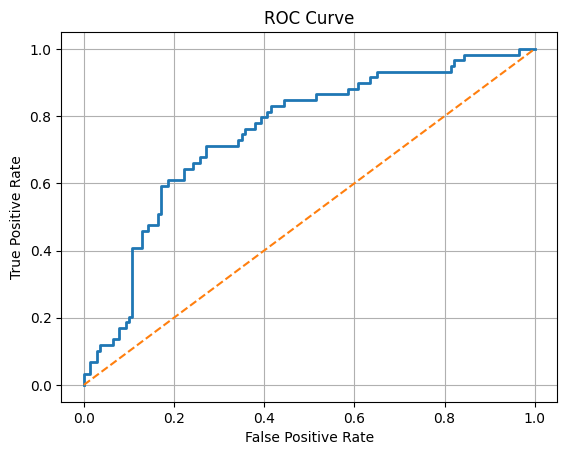


Features par importance :
Comptes                0.297399
Autres_credits         0.108041
Historique_credit      0.094790
Biens                  0.086161
Epargne                0.062274
Anciennete_emploi      0.059121
Taux_effort            0.057491
Age_cat                0.050653
Objet_credit           0.046833
Situation_familiale    0.046819
Statut_domicile        0.046134
Credit_ratio_cat       0.044285
dtype: float32


In [168]:
# Matrice de confusion

from sklearn.metrics import confusion_matrix, classification_report, roc_curve
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion :")
print(cm)
print("\nClassification report :")
print(classification_report(y_test, y_pred))


# Courbe ROC

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()


# Importance des features

importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
print("\nFeatures par importance :")
print(importances.sort_values(ascending=False).head(20))


Matrice de confusion

La matrice montre que le modèle prédit très bien la classe majoritaire (0) avec 137 vrais négatifs. Par contre, il détecte très mal la classe minoritaire (1) avec seulement 4 vrais positifs. Il y a beaucoup de faux négatifs (55), ce qui signifie que la majorité des observations positives sont mal classées.


Classification 

Pour la classe 0, le recall est de 0.98, ce qui confirme que le modèle capture presque toutes les observations de cette classe. La précision est de 0.71, ce qui reste correct.

Pour la classe 1, le recall est seulement de 0.07 et le F1-score de 0.12. Cela montre que le modèle échoue à identifier la majorité des cas positifs.


Performance globale

L’accuracy globale est de 0.71, mais ce chiffre peut être trompeur car il est dominé par la classe majoritaire. Le modèle est utile pour prédire la classe 0 mais inadapté si l’objectif principal est de détecter la classe 1. Pour améliorer la détection de la classe minoritaire, nous avons appliqué SMOTE, une technique de rééchantillonnage qui génère des exemples synthétiques de la classe minoritaire, ce qui permet au modèle de mieux apprendre et prédire les 1. 

### XGboost + SMOTE

XGBoost + SMOTE combine le modèle XGBoost avec la technique SMOTE pour gérer le déséquilibre des classes.
SMOTE crée des exemples synthétiques de la classe minoritaire, ce qui permet à XGBoost de mieux détecter les 1 tout en conservant sa puissance de prédiction.

In [169]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Avant SMOTE :", y_train.value_counts())
print("Après SMOTE :", y_train_res.value_counts())

Avant SMOTE : Cible
0    558
1    237
Name: count, dtype: Int64
Après SMOTE : Cible
0    558
1    558
Name: count, dtype: Int64


In [170]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

In [171]:
# Grid search 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [172]:
grid_search.fit(X_train_res, y_train_res)

best_xgb = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


c:\Users\Timothée\Documents\M2 ECAP\Modélisation du risque de crédit et scoring\projet_scoring\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Matrice de confusion :
 [[121  19]
 [ 36  23]]

Classification report :
               precision    recall  f1-score   support

         0.0       0.77      0.86      0.81       140
         1.0       0.55      0.39      0.46        59

    accuracy                           0.72       199
   macro avg       0.66      0.63      0.64       199
weighted avg       0.70      0.72      0.71       199

AUC ROC : 0.7179
Indice de Gini : 0.4358


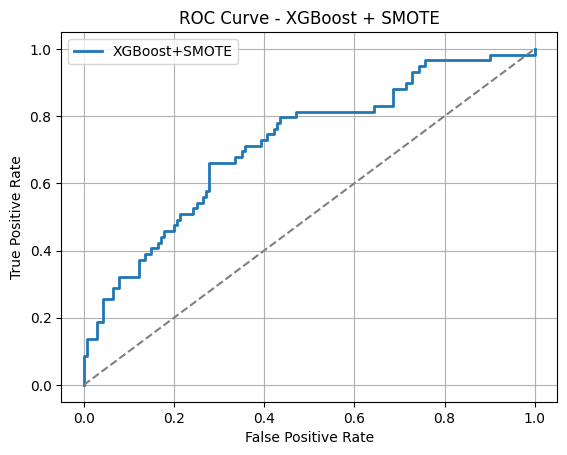

In [173]:
# predictions
y_proba = best_xgb.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)  # seuil 0.5

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion :\n", cm)

# Classification report
print("\nClassification report :\n", classification_report(y_test, y_pred))

# AUC et Gini
auc = roc_auc_score(y_test, y_proba)
gini = 2*auc - 1
print(f"AUC ROC : {auc:.4f}")
print(f"Indice de Gini : {gini:.4f}")

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost+SMOTE', linewidth=2)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost + SMOTE")
plt.legend()
plt.grid(True)
plt.show()

Nous avons utilisé un modèle XGBoost pour prédire la variable cible binaire. Comme le jeu de données était fortement déséquilibré, avec beaucoup plus de 0 que de 1, le modèle initial avait du mal à détecter la classe minoritaire (1). Pour y remédier, nous avons appliqué SMOTE (Synthetic Minority Over-sampling Technique) sur le jeu d’entraînement. Cette technique génère des observations synthétiques de la classe minoritaire afin de rééquilibrer les classes, ce qui permet au modèle d’apprendre davantage de motifs associés à la classe 1.

Après l’application de SMOTE, la performance globale du modèle est restée similaire avec une accuracy de 0.72, mais la capacité à détecter la classe minoritaire s’est nettement améliorée. En effet, le recall pour la classe 1 est passé de 0.07 à 0.39, et le F1-score a augmenté à 0.46. Cela signifie que le modèle réussit maintenant à identifier une proportion plus importante des observations positives, ce qui était l’objectif principal.

Pour la classe majoritaire (0), le modèle reste performant, avec un recall de 0.86 et un F1-score de 0.81. L’AUC ROC est de 0.718, ce qui indique que le modèle sépare bien globalement les deux classes. L’indice de Gini, à 0.436, confirme cette capacité de discrimination.

En résumé, l’utilisation de SMOTE a permis d’améliorer significativement la détection de la classe minoritaire sans trop affecter la performance sur la classe majoritaire, rendant le modèle plus équilibré et adapté à la prédiction des 1.

## AdaBoost

AdaBoost est un algorithme de boosting qui combine plusieurs arbres faibles (souvent des stumps) pour créer un modèle plus fort.
Il fonctionne en pondérant davantage les observations mal classées à chaque itération pour améliorer la précision sur les cas difficiles.

In [174]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Modèle AdaBoost
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # <-- ici
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

# Entraînement
ada_model.fit(X_train, y_train)

# Prédictions
y_proba = ada_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)


Matrice de confusion :
 [[124  16]
 [ 35  24]]

Classification report :
               precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       140
         1.0       0.60      0.41      0.48        59

    accuracy                           0.74       199
   macro avg       0.69      0.65      0.66       199
weighted avg       0.73      0.74      0.73       199

AUC ROC : 0.7592
Indice de Gini : 0.5184


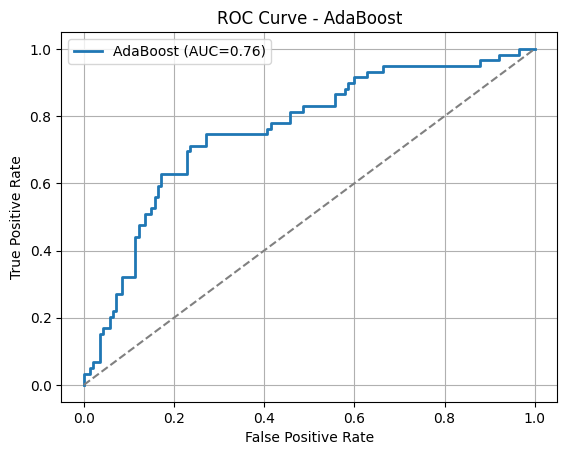

In [175]:
# Évaluation
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)
print("\nClassification report :\n", classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
gini = 2*auc - 1
print(f"AUC ROC : {auc:.4f}")
print(f"Indice de Gini : {gini:.4f}")

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AdaBoost (AUC={auc:.2f})', linewidth=2)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend()
plt.grid(True)
plt.show()

Performance globale : Accuracy correcte (~0.74), bonne prédiction de la classe majoritaire (0).  

Classe minoritaire (1) : Le modèle détecte mieux les 1 que XGBoost ou les modèles logit/probit, avec un recall de 0.41 et un F1-score de 0.48.  

Conclusion : Même sans rééchantillonnage, AdaBoost est capable de capturer une partie des clients à risque tout en conservant une bonne précision sur les clients "sûrs". Nous allons encore une fois tenter d'améliorer notre modèle en ajoutant la méthode de réchantillonage SMOTE.

## AdaBoost + SMOTE

AdaBoost + SMOTE combine le modèle AdaBoost avec la technique SMOTE pour gérer le déséquilibre des classes.
SMOTE crée des exemples synthétiques de la classe minoritaire, ce qui permet à AdaBoost de mieux détecter les 1 tout en conservant sa puissance de prédiction.

In [176]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# adaBoost
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # arbres faibles
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

# Entraînement avec les données rééchantillonnées
ada_model.fit(X_train_res, y_train_res)

# Prédictions
y_proba = ada_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)


Matrice de confusion :
 [[109  31]
 [ 22  37]]

Classification report :
               precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       140
         1.0       0.54      0.63      0.58        59

    accuracy                           0.73       199
   macro avg       0.69      0.70      0.69       199
weighted avg       0.75      0.73      0.74       199

AUC ROC : 0.7505
Indice de Gini : 0.5010


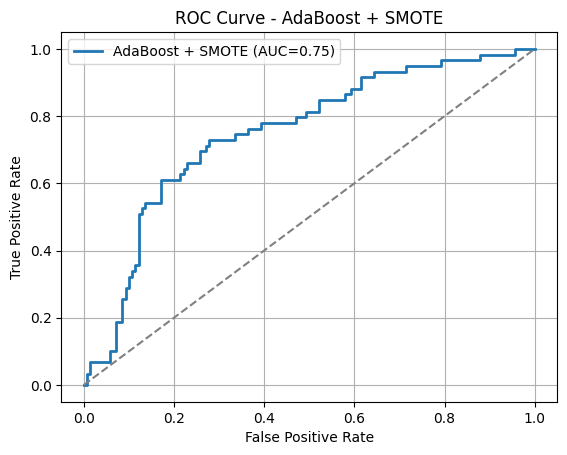

In [177]:
# Évaluation
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion :\n", cm)

print("\nClassification report :\n", classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
gini = 2*auc - 1
print(f"AUC ROC : {auc:.4f}")
print(f"Indice de Gini : {gini:.4f}")

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AdaBoost + SMOTE (AUC={auc:.2f})', linewidth=2)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost + SMOTE")
plt.legend()
plt.grid(True)
plt.show()

| Modèle               | Accuracy | Precision (0) | Recall (0) | F1-score (0) | Precision (1) | Recall (1) | F1-score (1) | AUC ROC | Gini  |
| -------------------- | -------- | ------------- | ---------- | ------------ | ------------- | ---------- | ------------ | ------- | ----- |
| Logit                | 0.71     | 0.76          | 0.86       | 0.81         | 0.51          | 0.36       | 0.42         | 0.723   | 0.446 |
| Probit               | 0.70     | 0.75          | 0.86       | 0.80         | 0.50          | 0.34       | 0.40         | 0.722   | 0.444 |
| XGBoost              | 0.71     | 0.71          | 0.98       | 0.83         | 0.57          | 0.07       | 0.12         | 0.750   | 0.501 |
| XGBoost + SMOTE  | 0.72     | 0.77          | 0.86       | 0.81         | 0.55          | 0.39       | 0.46         | 0.718   | 0.436 |
| AdaBoost             | 0.74     | 0.78          | 0.89       | 0.83         | 0.60          | 0.41       | 0.48         | 0.759   | 0.518 |
| AdaBoost + SMOTE | 0.73     | 0.83          | 0.78       | 0.80         | 0.54          | 0.63       | 0.58         | 0.751   | 0.501 |


**Explication des métriques** :  
- **Accuracy** : % de bonnes prédictions globales
- **Precision** : Exactitude des prédictions pour chaque classe
- **Recall** : Capacité à détecter tous les vrais de chaque classe
- **F1-score** : Compromis précision/recall
- **AUC ROC** : Qualité globale de séparation des classes
- **Gini** : Version transformée de l’AUC pour le scoring (2*AUC-1)
 